In [1]:
from simplex_projection import euclidean_proj_l1ball
from numpy.linalg import inv, solve

from matplotlib import pyplot as plt
import numpy as np

from numpy import linalg as LA

%matplotlib inline

In [2]:
def Z_update(beta, Y, delta, X, Tk, Pk):
    
    # Go col by col
    Z = np.zeros(Tk.shape)

    # store the inverse
    A_inv = inv(beta * Y.T.dot(Y) + (delta * np.eye(Y.shape[1])))
    b = (beta * Y.T.dot(X)) + (delta * Tk - Pk)
    Z = A_inv.dot(b)
    return Z

def T_update(Z_kp1, Pk, Rw, delta, sigma, zeta):
    
    T1 = Z_kp1 +(Pk / delta) - (Rw.dot(sigma) / delta) 
    T2 = conv_proj(T1, delta, zeta)
    
    return T1 - T2
def P_update(Pk, delta, Z_kp1, T_kp1):
    
    return Pk + delta * (Z_kp1 - T_kp1)

def conv_proj(A, delta, zeta):
    
    # Copy the input
    A_out = np.array(A, copy=True)
    
    # Go row by row through A
    for i in range(A_out.shape[0]):
        
        a = A_out[i,:]
        
        pos_ind = a > 0
        b = a[pos_ind]
        proj_b = euclidean_proj_l1ball(b, zeta / delta)
        
        np.put(a, np.where(pos_ind), proj_b)

    return A_out        

def hilbert_prod(A,B):
    
    return np.trace(A.dot(B.T))

def minimizer(X, Y, beta=250.0, delta=1.0, zeta=1.0, 
              h=(1-np.cos(4.0 * np.pi/180.0)), v=50.0,
              tol=0.2, max_iter=500):
    
    Tk = np.ones(Y.shape[1])
    Pk = np.random.randn(*Tk.shape)
    
    Rw = np.eye(Tk.shape[0])
    
    sigma = v*(1-np.exp(-(1 / (2 * h**2))*(1-(Y.T.dot(X)))**2))
    
    def L_del(Z,T,P):
        
        if(np.all(T >= 0)):
            g = 0.0
        else:
            g = 1000000000.0
            print 'should not be here'
        
       
        l1_inf = zeta * np.sum(np.amax(T,1))
        l1_ = hilbert_prod(Rw.dot(sigma), T)
      
        fidelity = (beta / 2.0) * hilbert_prod(Y.dot(Z) - X, Y.dot(Z) - X)
        
        lagrange = hilbert_prod(P, Z-T) + (delta/2.0)*hilbert_prod(Z-T, Z-T)
        
        return l1_inf + l1_ + fidelity + lagrange
        
    n=0
    converged = 1000000000.0
    objective = []
    while (n < max_iter) and (converged > tol):
        
        Z_kp1 = Z_update(beta, Y, delta, X, Tk, Pk)
        
        T_kp1 = T_update(Z_kp1, Pk, Rw, delta, sigma, zeta)
        
        
        P_kp1 = P_update(Pk, delta, Z_kp1, T_kp1)

        L = L_del(Z_kp1, T_kp1, P_kp1)
        Tk = T_kp1
        Pk = P_kp1
        
        if n == 0:
            L_old = L
            n = n+1
            continue
        converged = np.sum((L - L_old)**2)
        n = n+1
        objective.append(converged)
        L_old = L
    return Tk, objective

In [3]:
# Tests

# Test the projection onto the l1 ball
v = np.array([2.,3.])
proj_b = euclidean_proj_l1ball(v, 1.0)

print proj_b



[ 0.  1.]


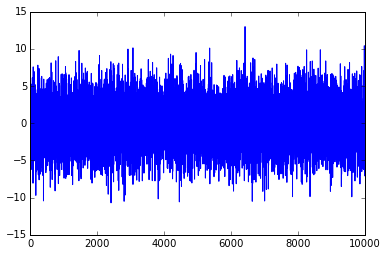

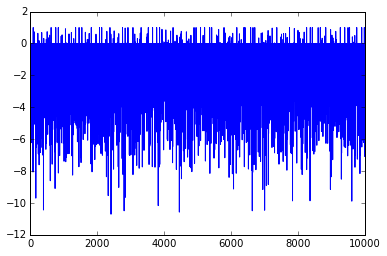

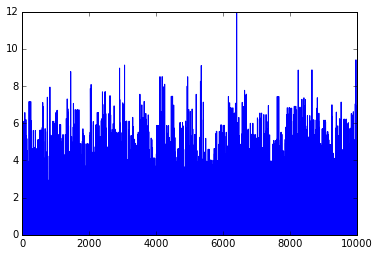

In [4]:
# test this
t = np.arange(10)
ev1, ev2, ev3 = np.sin(t*np.pi/2.0), np.sin(t*np.pi/5.0), np.sin(t*np.pi/8.0)

d = np.random.randn(100,100)*3.0
plt.figure
plt.plot(d.flatten())

proj_d = conv_proj(d, 1,1)
plt.figure()
plt.plot(proj_d.flatten())

plt.figure()
plt.plot(d.flatten() - proj_d.flatten())

In [5]:
dic = np.array([ev1,ev2,ev3]).T
mixer = np.zeros((3, 500))

index = np.random.choice(np.arange(mixer.shape[1]),
                                   mixer.shape[1], False)

mixer[0,:150] = 1.0
mixer[1,150:300] = 1.0
mixer[2,300:] = 1.0

data = dic.dot(mixer)
data += np.random.randn(*data.shape)*.2

data /= np.sum(np.abs(data),0)

(10, 500)

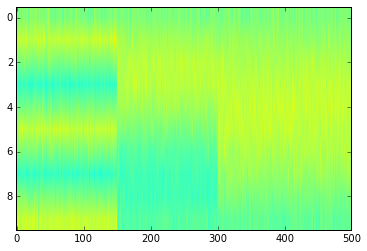

In [6]:
plt.imshow(data, clim=[-1,1], aspect='auto')
data.shape

In [18]:
X = data
Y = X
T, obj = minimizer(X, Y, beta=1000.0, zeta=600.0, delta=200.0, 
                   max_iter=1000, tol=0.0, v=40.0)

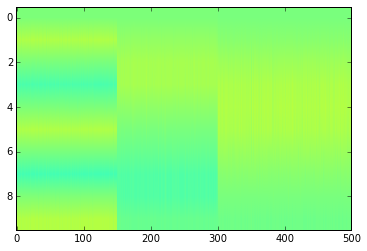

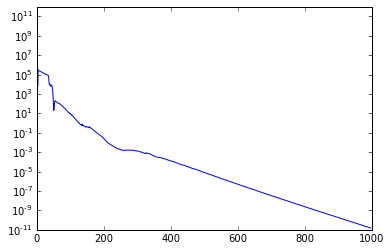

In [19]:
plt.figure()
plt.imshow(data.dot(T), clim=[-1,1], aspect='auto')
plt.figure()
plt.semilogy(obj)

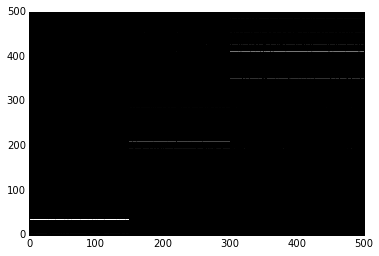

In [26]:
plt.pcolor(T, cmap='gray')

In [21]:
def unique_rows(a):
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

In [53]:
dic = unique_rows(T[np.sum(T,1) > 22.0]).T

In [54]:
basis = X.dot(dic)
basis.shape

(10, 4)

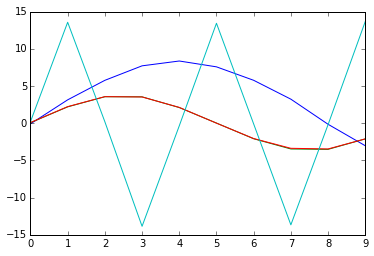

In [55]:
plt.plot(basis)

In [49]:
X.dot(basis.T).shape

ValueError: shapes (10,500) and (5,10) not aligned: 500 (dim 1) != 5 (dim 0)

In [50]:
X.dot(basis.T)

ValueError: shapes (10,500) and (5,10) not aligned: 500 (dim 1) != 5 (dim 0)